In [1]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary

import matplotlib.pyplot as plt
from timeit import default_timer as timer

import numpy as np

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

# Check out what is inside the training data loader
train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [2]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

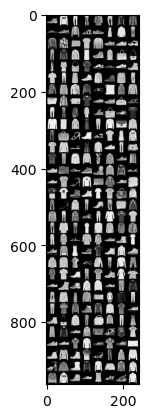

In [3]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))

In [4]:
img,label=trainset[1]
print(label)
#display(img)

0


In [5]:
lookup_dict={
    0 :'T-shirt/top',
    1 :'Trouser',
    2 :'Pullover',
    3 :'Dress',
    4 :'Coat',
    5 :'Sandal',
    6 :'Shirt',
    7 :'Sneaker',
    8 :'Bag',
    9 :'Ankle boot'}
print(lookup_dict[label])

T-shirt/top


In [6]:
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.act=torch.nn.ReLU()
        self.fc1   = nn.Linear(32 * 7 * 7, output_size)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.pool(x)
        x = self.act(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Flatten
        return self.fc1(x)

In [7]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    model.train()  
    total_loss = 0
    correct = 0
    total_samples = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        l2_reg = sum((p ** 2).sum() for p in model.parameters())
        loss += reg_param * l2_reg
        total_loss = loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()  
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)
    train_loss = total_loss / len(train_loader)  
    train_acc = (correct / total_samples) * 100 

    return train_loss.item(), train_acc

In [8]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            l2_reg = sum((p ** 2).sum() for p in model.parameters())
            loss += reg_param * l2_reg
            total_loss = loss
            total_loss += loss.item()  
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    valid_loss = total_loss / len(train_loader)  
    valid_acc = (correct / total_samples) * 100 

    return valid_loss.item(), valid_acc

In [9]:
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    # Make device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    torch.manual_seed(random_seed)  # do not change this
    epochs = 50
    learning_rate = 1e-3
    reg_param = 1e-5
    
    sample_input, sample_label = next(iter(train_loader))
    input_size = sample_input.shape[1]
    output_size = len(torch.unique(sample_label))
    model = ConvModel(input_size, output_size).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5)

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        valid_loss, valid_acc = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        test_loss, test_acc = evaluation_step(model, test_loader, loss_fn, reg_param, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%")
            print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")
    


    return model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies
    

In [10]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):
    epochs = range(1, 51)  
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, valid_accuracies, label="Valid Accuracy")
    plt.plot(epochs, test_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training, Valid, and Test Accuracy Over Epochs")
    plt.legend()
    plt.show()

In [11]:
def plot_loss_performance(train_losses, valid_accuracies, test_losses):
    epochs = range(1, 51)  
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Valid Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training, Valid, and Test Loss Over Epochs")
    plt.legend()
    plt.show()

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
random_seed = 1
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

Epoch 5/50 - Train Loss: 0.0043, Train Acc: 88.49%
Valid Loss: 0.0036, Valid Acc: 88.33%
Test Loss: 0.0032, Test Acc: 88.33%

Epoch 10/50 - Train Loss: 0.0019, Train Acc: 90.13%
Valid Loss: 0.0028, Valid Acc: 89.54%
Test Loss: 0.0027, Test Acc: 89.54%

Epoch 15/50 - Train Loss: 0.0018, Train Acc: 91.24%
Valid Loss: 0.0025, Valid Acc: 90.20%
Test Loss: 0.0028, Test Acc: 90.20%

Epoch 20/50 - Train Loss: 0.0033, Train Acc: 91.95%
Valid Loss: 0.0022, Valid Acc: 90.61%
Test Loss: 0.0033, Test Acc: 90.61%

Epoch 25/50 - Train Loss: 0.0023, Train Acc: 92.67%
Valid Loss: 0.0022, Valid Acc: 90.99%
Test Loss: 0.0030, Test Acc: 90.99%

Epoch 30/50 - Train Loss: 0.0014, Train Acc: 93.02%
Valid Loss: 0.0025, Valid Acc: 90.86%
Test Loss: 0.0032, Test Acc: 90.86%

Epoch 35/50 - Train Loss: 0.0021, Train Acc: 93.58%
Valid Loss: 0.0030, Valid Acc: 91.16%
Test Loss: 0.0025, Test Acc: 91.16%

Epoch 40/50 - Train Loss: 0.0021, Train Acc: 94.03%
Valid Loss: 0.0037, Valid Acc: 90.88%
Test Loss: 0.0028, Tes

In [ ]:
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

In [ ]:
plot_loss_performance(train_losses, valid_losses, test_losses)